# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize to cummulative reward by chosing the right action in the states.

As the name suggests, GAIL falls into a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimik an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller to actions which deviate from the expert behavior much. In our case, expert trajectories were generated from real life data, namely from the interaction dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are gained in this way represent the expert knowladge by containing many states and the corresponding actions which were produced by the expert.

A said, the learning of the agent in the RL setting is driven by the rewards it receives from the environmen. The amount of the reward in the Imitation Learning case are determined based on how closely the agent mimics the expert behavior. Furthermore, specially in the GAIL approach we get the reward from an adversarial game: The agent is represented by the generator network, which is trained based on the feedback of the discriminator network. The generator produces actions for given states, which are then judged by the discriminator. In the meantime the discriminator is trained by feeding it expert and agent state-action pairs for classification. In this way the generator tries to fool the discriminator, hence tries to act as expert-like as possible, meanwhile the discriminator tries to identify expert and agent trajectories from eachother. Intuitively the learning converges, when the generator learned to act so similarly to the expert that the discriminator can not tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has got 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step for minimizing the it.
As said, the training goes until both the generator and the discriminator loss converge to a stady state value. The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

## Interaction Dataset
As a data source, we used the interaction dataset: https://arxiv.org/abs/1910.03088. Here, we are interested in the merging scenarios: deu_merging_mt and chn_merging_zs. Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (Note that the dataset itself is NOT enclosed with bark due to license limitations).

## Expert Trajectories
As said, we have generated expert trajectories using the Interaction Dataset and also a trained SAC agent. The Interaction Dataset of course contains logs about many different vehicles with different wheel bases. To remedy this issue, we have used a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data, we just consider that all state trajectories were carried out by the same car and calculate the actions that car would have required to carrie out that behavior. 

As the state variables and also the actions have diferent magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the actual environment (BARK runtime) as an input, hence the trajectories can be normalized according to the current parameters. (Current state and action spaces.)

## Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset are shown in the followings. 

In [9]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
generation_params = param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]
generation_params["TrackIds"] = [63, 64, 65, 66, 67, 68]
generation_params["StartTs"] = 232000
generation_params["EndTs"] = 259000
generation_params["EgoTrackId"] = ego_agent
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"] = generation_params

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

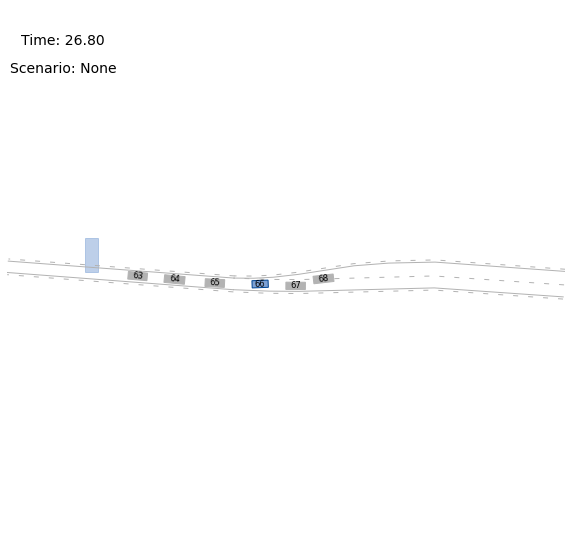

In [10]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The generated expert trajectories:
The generated expert trajectories are stored in a dictionary with keys:
* `obs`: list, containing the observation vector for the timestep.
* `act`: list, containing the action that was carried out in that timestep.
* `next_obs`: list, the next observation after carrying out the action `act` in the state `obs`. 

The following 2 cells show some example states and actions for being able to better understanding the format.

In [11]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([ 998.184021  , 1006.93701172,    3.08599997,    2.19539237,
        995.9619751 , 1004.27398682,    3.05999994,    1.66448367,
       1004.67498779, 1006.34100342,    3.06100011,    1.7957828 ,
       1004.05700684, 1003.58398438,    3.07299995,    1.92759383]),
 array([ 997.74597168, 1006.9619751 ,    3.08599997,    2.18845916,
        995.63201904, 1004.30102539,    3.05999994,    1.62844038,
       1004.31799316, 1006.36901855,    3.06200004,    1.77660406,
       1003.67797852, 1003.60699463,    3.07500005,    1.82607996]),
 array([ 997.30999756, 1006.98699951,    3.08500004,    2.17947364,
        995.309021  , 1004.32800293,    3.05900002,    1.59439075,
       1003.96502686, 1006.39697266,    3.06200004,    1.75758469,
       1003.31799316, 1003.62902832,    3.07599998,    1.72271013]),
 array([ 996.875     , 1007.01202393,    3.08500004,    2.16549611,
        994.99298096, 1004.35498047,    3.05900002,    1.56133819,
       1003.61499023,

In [12]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[-0.034666060884802626, 0.0],
 [-0.044927593029058605, -0.006168197873944377],
 [-0.06988764225766911, 0.0],
 [-0.09983778594957507, -0.006233605047211027],
 [-0.1200890254762112, 0.0]]


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement algorithms and training methods in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with the actor and critic networks. Both of them has 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect the agent is not in the traditional GAIL setup with 2 neural networks, but instead it actually has 5 networks, since the DDPG agent it self has got 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the Discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of tf2rl about the environment. The observation and action normalization also takes place here.
    * source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is shown. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [13]:
# Costumise some parameters here!!! #

max_steps = 100000          # Number of steps to train for.
test_interval = 100         # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [14]:
# IMPORTS
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories


The next cell deletes the previous logs and launches tensorboard. After tensorboard has launced, please go on to the next cell and start the training. The tensorboard window refreshes it self in every 30 secs, but you can also refresh it by hand in the top right corner.

In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# launching tensorboard and deleting the previous runs logdirs:
!kill 119065
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
zsh:kill:1: kill 119065 failed: no such process


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
11:52:34.233 [INFO] (trainer.py:65) Restored None
11:52:34.279 [INFO] (irl_trainer.py:73) Total Epi:     1 Steps:       5 Episode Steps:     5 Return: -1.0000 FPS: 114.93
11:52:34.625 [INFO] (irl_trainer.py:73) Total Epi:     2 Steps:      10 Episode Steps:     5 Return: -1.0000 FPS: 873.80
11:52:34.633 [INFO] (irl_trainer.py:73) Total Epi:     3 Steps:      18 Episode Steps:     8 Return: -1.0000 FPS: 1200.08
11:52:34.638 [INFO] (irl_trainer.py:73) Total Epi:     4 Steps:      20 Episode Steps:     2 Return: -1.0000 FPS: 593.84
11:52:34.644 [INFO] (irl_trainer.py:73) Total Epi:     5 Steps:      24 Episode Steps:     4 Return: 

11:52:35.192 [INFO] (irl_trainer.py:73) Total Epi:    66 Steps:     579 Episode Steps:     3 Return: -1.0000 FPS: 657.52
11:52:35.203 [INFO] (irl_trainer.py:73) Total Epi:    67 Steps:     591 Episode Steps:    12 Return: -1.0000 FPS: 1281.56
11:52:35.224 [INFO] (irl_trainer.py:73) Total Epi:    68 Steps:     620 Episode Steps:    29 Return:  1.0000 FPS: 1497.73
11:52:35.232 [INFO] (irl_trainer.py:73) Total Epi:    69 Steps:     624 Episode Steps:     4 Return: -1.0000 FPS: 637.52
11:52:35.237 [INFO] (irl_trainer.py:73) Total Epi:    70 Steps:     626 Episode Steps:     2 Return: -1.0000 FPS: 547.95
11:52:35.243 [INFO] (irl_trainer.py:73) Total Epi:    71 Steps:     629 Episode Steps:     3 Return: -1.0000 FPS: 712.16
11:52:35.254 [INFO] (irl_trainer.py:73) Total Epi:    72 Steps:     640 Episode Steps:    11 Return: -1.0000 FPS: 1124.26
11:52:35.260 [INFO] (irl_trainer.py:73) Total Epi:    73 Steps:     645 Episode Steps:     5 Return: -1.0000 FPS: 992.77
11:52:35.266 [INFO] (irl_trai


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



11:52:38.507 [INFO] (irl_trainer.py:73) Total Epi:   120 Steps:    1015 Episode Steps:    28 Return:  1.0000 FPS: 10.43
11:52:38.709 [INFO] (irl_trainer.py:73) Total Epi:   121 Steps:    1029 Episode Steps:    14 Return: -1.0000 FPS: 70.29
11:52:38.805 [INFO] (irl_trainer.py:73) Total Epi:   122 Steps:    1036 Episode Steps:     7 Return: -1.0000 FPS: 73.50
11:52:38.895 [INFO] (irl_trainer.py:73) Total Epi:   123 Steps:    1042 Episode Steps:     6 Return: -1.0000 FPS: 68.13
11:52:38.972 [INFO] (irl_trainer.py:73) Total Epi:   124 Steps:    1047 Episode Steps:     5 Return: -1.0000 FPS: 66.45
11:52:39.020 [INFO] (irl_trainer.py:73) Total Epi:   125 Steps:    1050 Episode Steps:     3 Return: -1.0000 FPS: 63.52
11:52:39.067 [INFO] (irl_trainer.py:73) Total Epi:   126 Steps:    1053 Episode Steps:     3 Return: -1.0000 FPS: 67.24
11:52:39.119 [INFO] (irl_trainer.py:73) Total Epi:   127 Steps:    1056 Episode Steps:     3 Return: -1.0000 FPS: 59.52
11:52:39.153 [INFO] (irl_trainer.py:73) 

11:52:46.817 [INFO] (irl_trainer.py:73) Total Epi:   189 Steps:    1547 Episode Steps:     8 Return: -1.0000 FPS: 57.68
11:52:47.030 [INFO] (irl_trainer.py:73) Total Epi:   190 Steps:    1561 Episode Steps:    14 Return: -1.0000 FPS: 66.13
11:52:47.336 [INFO] (irl_trainer.py:73) Total Epi:   191 Steps:    1582 Episode Steps:    21 Return: -1.0000 FPS: 69.07
11:52:47.811 [INFO] (irl_trainer.py:73) Total Epi:   192 Steps:    1612 Episode Steps:    30 Return: -1.0000 FPS: 63.40
11:52:48.264 [INFO] (irl_trainer.py:73) Total Epi:   193 Steps:    1643 Episode Steps:    31 Return: -1.0000 FPS: 68.63
11:52:48.486 [INFO] (irl_trainer.py:73) Total Epi:   194 Steps:    1658 Episode Steps:    15 Return: -1.0000 FPS: 68.24
11:52:48.834 [INFO] (irl_trainer.py:73) Total Epi:   195 Steps:    1681 Episode Steps:    23 Return: -1.0000 FPS: 66.30
11:52:49.160 [INFO] (irl_trainer.py:73) Total Epi:   196 Steps:    1701 Episode Steps:    20 Return: -1.0000 FPS: 61.75
11:52:49.255 [INFO] (irl_trainer.py:73) 

11:53:03.441 [INFO] (irl_trainer.py:73) Total Epi:   257 Steps:    2622 Episode Steps:    14 Return: -1.0000 FPS: 68.56
11:53:03.586 [INFO] (irl_trainer.py:73) Total Epi:   258 Steps:    2632 Episode Steps:    10 Return: -1.0000 FPS: 69.95
11:53:03.688 [INFO] (irl_trainer.py:73) Total Epi:   259 Steps:    2639 Episode Steps:     7 Return: -1.0000 FPS: 69.53
11:53:03.893 [INFO] (irl_trainer.py:73) Total Epi:   260 Steps:    2653 Episode Steps:    14 Return: -1.0000 FPS: 68.78
11:53:04.128 [INFO] (irl_trainer.py:73) Total Epi:   261 Steps:    2669 Episode Steps:    16 Return: -1.0000 FPS: 68.72
11:53:04.361 [INFO] (irl_trainer.py:73) Total Epi:   262 Steps:    2685 Episode Steps:    16 Return: -1.0000 FPS: 69.13
11:53:04.632 [INFO] (irl_trainer.py:73) Total Epi:   263 Steps:    2702 Episode Steps:    17 Return: -1.0000 FPS: 63.15
11:53:04.737 [INFO] (irl_trainer.py:73) Total Epi:   264 Steps:    2709 Episode Steps:     7 Return: -1.0000 FPS: 67.77
11:53:04.944 [INFO] (irl_trainer.py:73) 

KeyboardInterrupt: 

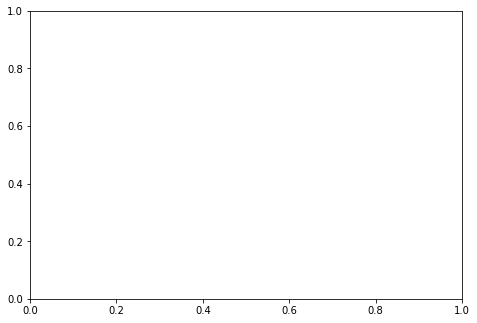

In [8]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                                number_of_senarios=500,
                                random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                         render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
                           normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                               params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params['ML']['ExpertTrajectories']['expert_path_dir'],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env, # the unwrapped env has to be used, since that contains the unnormalized spaces.
    subset_size=params["ML"]["ExpertTrajectories"]["subset_size"]
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization:
Please set up the number of scenarios to visualize in the next cell!

In [16]:
# Number of scenarios to visualize:
num_scenarios_to_visualize = 10

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

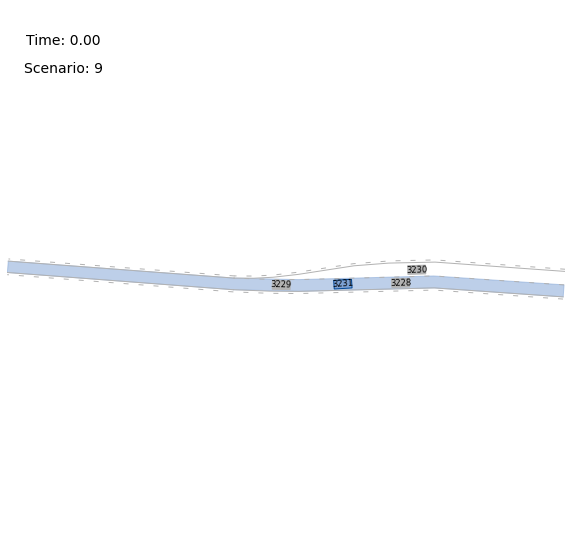

In [17]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = "../../../com_github_gail_4_bark_large_data_store/pretrained_agents/gail/merging"

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")